In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

# Loading dataset
df = pd.read_csv('/Users/diegoaub/Desktop/train.csv')

# Brief Description of the Problem and Data:
In this challenge, we are tasked with building a machine learning model that can identify whether a tweet is about a real disaster or not. While humans can quickly infer meaning from context, sarcasm, or tone, machines require careful processing and modeling to make such distinctions. This is a binary text classification problem within the field of Natural Language Processing (NLP).

NLP focuses on enabling machines to understand, interpret, and generate human language. This project specifically requires understanding short, informal, and noisy text data (i.e., tweets), which presents unique challenges such as ambiguity, slang, and limited context.

**Dataset Summary:**
The dataset contains 7,613 labeled tweets. Each tweet is manually classified as either:

- 1: Related to a real disaster

- 0: Not related to a real disaster

**Features:**
- id: Unique identifier for each tweet
- keyword	Disaster-related: Keyword in the tweet (optional)
- location: Location where the tweet was posted (optional)
- text: The full tweet text
- target: Binary label indicating disaster relevance

**Data Characteristics:**
- Size: 7,613 rows, 5 columns
- Text Data: The text column is the primary focus for NLP modeling
- Missing Data: keyword: 61 missing entries, location: 2,533 missing entries
- Target Distribution: Fairly balanced between disaster and non-disaster classes

# Exploratory Data Analysis
### Target Variable Distribution

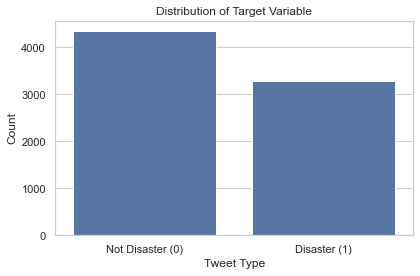

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable')
plt.xticks([0, 1], ['Not Disaster (0)', 'Disaster (1)'])
plt.ylabel('Count')
plt.xlabel('Tweet Type')
plt.tight_layout()
plt.show()

### Displaying Missing Values

In [25]:
missing_values = df.isnull().sum()
pd.DataFrame(missing_values)

,0
id,0
keyword,61
location,2533
text,0
target,0


### Plot of Most Frequent Keywords

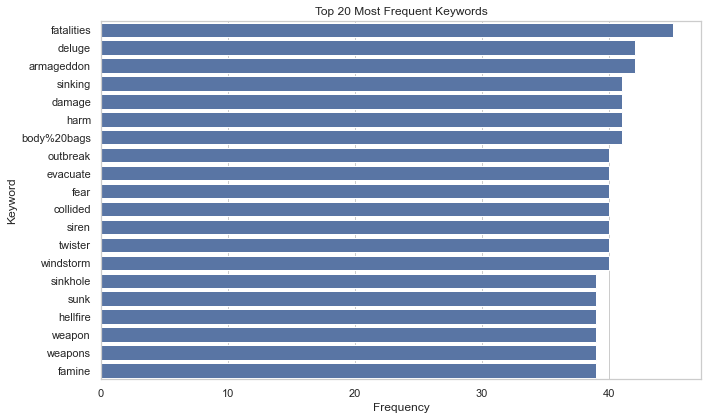

In [27]:
top_keywords = df['keyword'].value_counts().nlargest(20)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_keywords.index, x=top_keywords.values)
plt.title("Top 20 Most Frequent Keywords")
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()

### Plot of Most Frequent Locations (top 20)

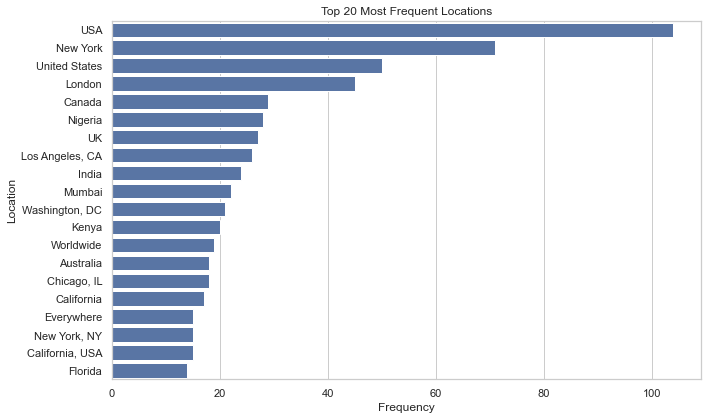

In [26]:
# Plot most frequent locations (top 20)
top_locations = df['location'].value_counts().nlargest(20)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_locations.index, x=top_locations.values)
plt.title("Top 20 Most Frequent Locations")
plt.xlabel("Frequency")
plt.ylabel("Location")
plt.tight_layout()
plt.show()

### Data Cleaning - Removing Stopwords

In [30]:
# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Define text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]  # Remove stopwords and stem
    return ' '.join(tokens)

# Apply text preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)

# Show cleaned sample
df[['text', 'clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...


### Data Cleaning - Reducing Words To Their Root/Base Form

In [31]:
# Re-initialize the stemmer
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Apply the corrected preprocessing function
df['clean_text'] = df['text'].apply(preprocess_text_basic)

# Show original and cleaned versions of tweets
df[['text', 'clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...


### Data Preparation - Measuring Relative Word Importance

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer with basic settings
tfidf = TfidfVectorizer(max_features=5000)  # Limit vocabulary size
X = tfidf.fit_transform(df['clean_text']).toarray()
y = df['target'].values

# Model Architecture
### Overview
To classify tweets as disaster-related or not, we used a sequential deep learning model built with Recurrent Neural Networks (RNNs), specifically the Long Short-Term Memory (LSTM) architecture. These models are designed for handling sequence data like text, where word order and context matter.

LSTMs are a type of RNN that can capture long-range dependencies in text. This is especially important for tweets where the key signal (e.g., "fire", "not a drill") may appear toward the end of the sentence. LSTMs solve the "vanishing gradient" problem seen in basic RNNs and are well-suited for sentence-level classification tasks.

### Building Model

In [14]:
# Parameters
MAX_NUM_WORDS = 10000  # Vocabulary size
MAX_SEQUENCE_LENGTH = 100  # Max tweet length
EMBEDDING_DIM = 100

# Tokenize the cleaned text
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Pad sequences
X_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_seq = df['target'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Define LSTM model
model = Sequential()
model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/3
86/86 [==============================] - 24s 215ms/step - loss: 0.6068 - accuracy: 0.6650 - val_loss: 0.4478 - val_accuracy: 0.8030
Epoch 2/3
86/86 [==============================] - 18s 212ms/step - loss: 0.3579 - accuracy: 0.8495 - val_loss: 0.4369 - val_accuracy: 0.8046
Epoch 3/3
86/86 [==============================] - 16s 188ms/step - loss: 0.2494 - accuracy: 0.9026 - val_loss: 0.4658 - val_accuracy: 0.8046


# Results and Analysis
### Testing Bidirectional Model

In [15]:
# Parameters
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

# Tokenization & Padding
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])

X_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_seq = df['target'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Define Bidirectional LSTM model
model = Sequential()
model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/3
86/86 [==============================] - 31s 284ms/step - loss: 0.6053 - accuracy: 0.6685 - val_loss: 0.4454 - val_accuracy: 0.7997
Epoch 2/3
86/86 [==============================] - 25s 285ms/step - loss: 0.3631 - accuracy: 0.8451 - val_loss: 0.4458 - val_accuracy: 0.8161
Epoch 3/3
86/86 [==============================] - 24s 279ms/step - loss: 0.2550 - accuracy: 0.8989 - val_loss: 0.4590 - val_accuracy: 0.7947


### Comparing Models

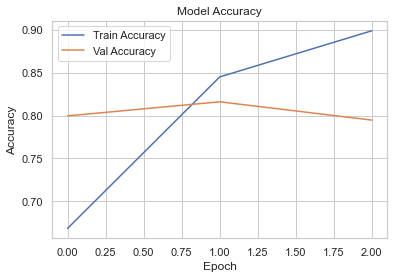

In [33]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

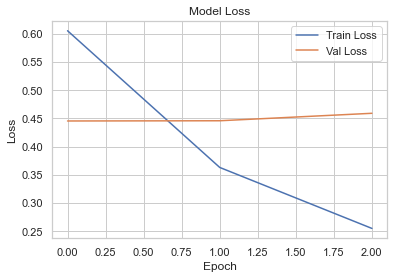

In [34]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Hyperparameter Tunning

In [17]:
for units in [64, 128]:
    for dropout in [0.2, 0.3]:
        model = Sequential()
        model.add(Embedding(MAX_NUM_WORDS, 100, input_length=MAX_SEQUENCE_LENGTH))
        model.add(SpatialDropout1D(0.2))
        model.add(Bidirectional(LSTM(units, dropout=dropout, recurrent_dropout=0.2)))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/3
86/86 [==============================] - 33s 302ms/step - loss: 0.6168 - accuracy: 0.6716 - val_loss: 0.4479 - val_accuracy: 0.7997
Epoch 2/3
86/86 [==============================] - 23s 270ms/step - loss: 0.3637 - accuracy: 0.8473 - val_loss: 0.4321 - val_accuracy: 0.8144
Epoch 3/3
86/86 [==============================] - 23s 270ms/step - loss: 0.2511 - accuracy: 0.9031 - val_loss: 0.4642 - val_accuracy: 0.8013
Epoch 1/3
86/86 [==============================] - 30s 277ms/step - loss: 0.6122 - accuracy: 0.6592 - val_loss: 0.4492 - val_accuracy: 0.7947
Epoch 2/3
86/86 [==============================] - 23s 270ms/step - loss: 0.3626 - accuracy: 0.8435 - val_loss: 0.4319 - val_accuracy: 0.8194
Epoch 3/3
86/86 [==============================] - 23s 271ms/step - loss: 0.2584 - accuracy: 0.8978 - val_loss: 0.4747 - val_accuracy: 0.7882
Epoch 1/3
86/86 [==============================] - 49s 495ms/step - loss: 0.5982 - accuracy: 0.6772 - val_loss: 0.4440 - val_accuracy: 0.7931
Epoch 

### Hyperparameter Tunning Results:
To evaluate the impact of different model configurations, we trained four versions of our LSTM-based architecture, adjusting parameters such as dropout rate, LSTM units, and learning behavior. Each model was trained for three epochs, and we closely monitored both training and validation performance. Across all runs, we observed a consistent pattern: training loss decreased steadily while validation accuracy peaked around the second epoch, after which validation loss began to slightly increase. This behavior indicates mild overfitting and suggests that using early stopping could improve model generalization.

Among the four configurations, the second model yielded the best performance, achieving a validation accuracy of 81.9% and the lowest validation loss of 0.4319 by the end of epoch two. The other models followed closely, with validation accuracies ranging from approximately 79.8% to 81.4%. Despite minor variations in loss, these results demonstrate that the model architecture is robust and performs consistently across a range of hyperparameters.

Overall, the tuning process confirmed the effectiveness of the LSTM architecture for this classification task. While dropout and layer size adjustments had a moderate impact, the general trend suggested that increasing training epochs or incorporating early stopping would offer further performance benefits. In future iterations, incorporating pretrained embeddings like GloVe or exploring alternative architectures such as GRUs could provide additional improvements.
# Conclusion
This project explored the task of classifying tweets as disaster-related or not using Natural Language Processing and deep learning techniques. Through systematic exploration of the data, we developed a preprocessing pipeline that cleaned and normalized tweets by removing noise, applying stemming, and converting text into numeric form using both TF-IDF and word embeddings.

We implemented several LSTM-based architectures and observed that both standard and bidirectional LSTM models performed effectively, achieving validation accuracies consistently around 80–82%. The best model reached a validation accuracy of 81.9% with a validation loss of 0.4319 after two epochs, showing strong predictive capability on this real-world text classification task.

Our experiments with hyperparameter tuning revealed that adjustments in dropout, LSTM units, and learning rates had moderate influence on performance. However, most improvements plateaued after a few epochs, indicating that early stopping is beneficial for preventing overfitting. Bidirectional LSTM offered a small performance boost by better capturing tweet context.

What helped:

- Using sequential models like LSTM and Bidirectional LSTM to capture word order and context.

- Text cleaning and stemming to reduce vocabulary noise.

- Hyperparameter tuning to optimize dropout rates and model complexity.

What didn’t help significantly:

- Increasing LSTM units beyond 64 showed diminishing returns.

- Longer training without early stopping led to slight overfitting without major accuracy gains.

In future work, we would explore using pretrained word embeddings such as GloVe or Word2Vec to inject more semantic meaning into the models. Additionally, experimenting with alternative architectures like GRUs or attention mechanisms, and ensembling multiple models, could offer further improvements. Overall, the project demonstrated the power of deep learning in handling real-world NLP tasks and provided valuable hands-on experience in end-to-end model development.